In [1]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
import getpass
import importlib
import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')


## Ipsilateral avg RDM

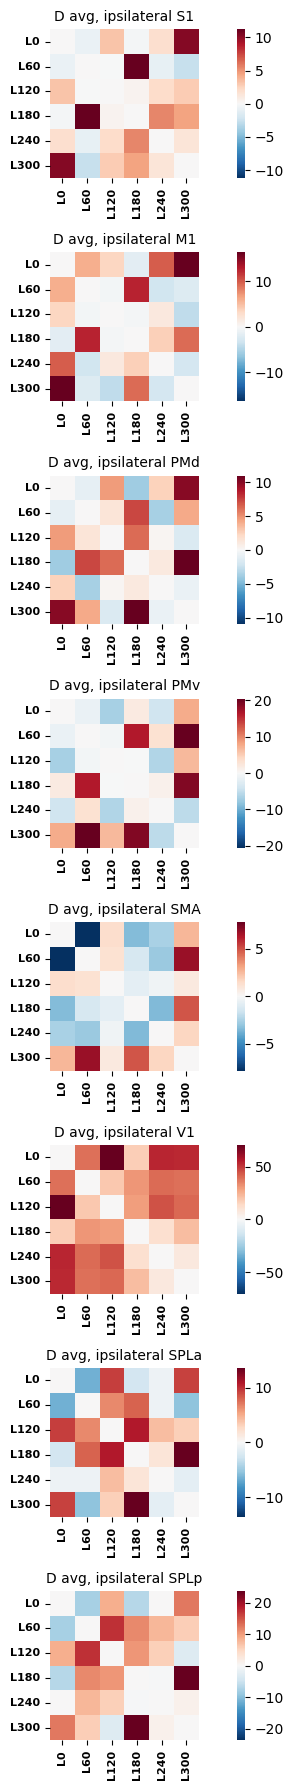

In [8]:
# load single hand move G matrices:
df_lhand = pd.read_feather(os.path.join(analysisDir, 'G_left_uni.feather'))
df_rhand = pd.read_feather(os.path.join(analysisDir, 'G_right_uni.feather'))

lhand_cols = ['lhand:0','lhand:60','lhand:120','lhand:180','lhand:240','lhand:300']
rhand_cols = ['rhand:180','rhand:120','rhand:60','rhand:0','rhand:300','rhand:240']

labels = ['L0','L60','L120','L180','L240','L300']
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

sn_list = df_lhand.sn.unique()
hem = df_lhand.hem.unique()
regions = df_lhand.region.unique()

G_matrices = {}
for sn in sn_list:
    for region in region_names:
        # get left hem for left hand:
        row = df_lhand[(df_lhand.sn == sn) & (df_lhand.hem == 'L') & (df_lhand.region == region)]
        # reconstruct G matrix:
        G_hat = utils.please.retrieve_matrix(row, prefix='G', colnames=lhand_cols)
        key = (sn, 'L', region)
        G_matrices[key] = G_hat

        # get right hem for right hand:
        row = df_rhand[(df_rhand.sn == sn) & (df_rhand.hem == 'R') & (df_rhand.region == region)]
        # reconstruct G matrix:
        G_hat = utils.please.retrieve_matrix(row, prefix='G', colnames=rhand_cols)
        key = (sn, 'R', region)
        G_matrices[key] = G_hat

# Average G matrix:
G_avg = my_dict = {name: np.zeros((6,6),dtype=np.float64) for name in region_names}
# D_avg = {name: np.zeros((6,6),dtype=np.float64) for name in region_names}
for sn in sn_list:
    for region in region_names:
        key = (sn, 'L', region)
        G_avg[region] += G_matrices[key] / len(sn_list) / 2

        key = (sn, 'R', region)
        G_avg[region] += G_matrices[key] / len(sn_list) / 2

cmap = matplotlib.cm.RdBu.reversed()
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8,18))
for i, region in enumerate(region_names):
    ax = axes[i]
    G_hat = G_avg[region]
    v_max = np.max(G_hat)
    v_min = np.min(G_hat)
    v_max = max(abs(v_max), abs(v_min))
    sns.heatmap(G_hat, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
    ax.set_title(f'G avg, ipsilateral {region}', fontsize=10)

    # Set labels manually with more formatting options
    ax.set_xticks(np.arange(0,len(labels))+0.5)
    ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
    ax.set_yticks(np.arange(0,len(labels))+0.5)
    ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../figures/direction_encoding/G_ipsi.pdf', bbox_inches="tight")
plt.close()

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8,18))
for i, region in enumerate(region_names):
    ax = axes[i]
    D = pcm.G_to_dist(G_avg[region])
    v_max = np.max(D)
    v_min = np.min(D)
    v_max = max(abs(v_max), abs(v_min))
    sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
    ax.set_title(f'D avg, ipsilateral {region}', fontsize=10)
    
    # Set labels manually with more formatting options
    ax.set_xticks(np.arange(0,len(labels))+0.5)
    ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
    ax.set_yticks(np.arange(0,len(labels))+0.5)
    ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../figures/direction_encoding/D_ipsi.pdf', bbox_inches="tight")
plt.show()

## Contralateral avg RDM

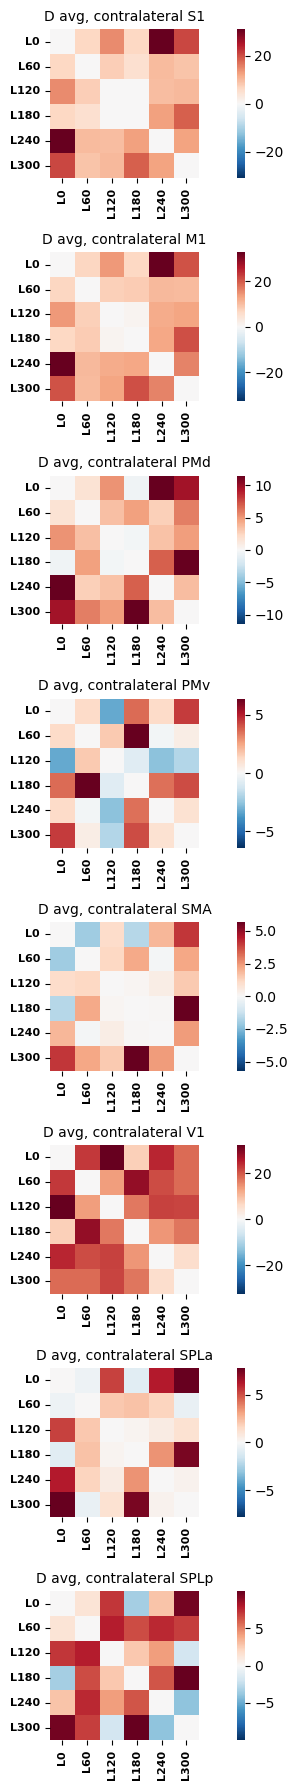

In [9]:
df_lbi = pd.read_feather(os.path.join(analysisDir, 'G_uni_bi_left.feather'))
df_rbi = pd.read_feather(os.path.join(analysisDir, 'G_uni_bi_right.feather'))

region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

rdm_cols = {'lbi':['lhand:0', 'lhand:60', 'lhand:120', 'lhand:180', 'lhand:240', 'lhand:300',
                   'bi:0', 'bi:60', 'bi:120', 'bi:180', 'bi:240', 'bi:300'],
            'rbi':['rhand:180','rhand:120','rhand:60','rhand:0','rhand:300','rhand:240',
                   'bi:180','bi:120','bi:60','bi:0','bi:300','bi:240']}

labels = ['L0','L60','L120','L180','L240','L300']

G_matrices = {}
for sn in sn_list:
    for region in region_names:
        # get left hem for left hand:s
        row = df_lbi[(df_lbi.sn == sn) & (df_lbi.hem == 'R') & (df_lbi.region == region)]
        # reconstruct G matrix:
        G_hat = utils.please.retrieve_matrix(row, prefix='G', colnames=rdm_cols['lbi'])
        key = (sn, 'R', region)
        G_matrices[key] = G_hat
       
        # get right hem for right hand:
        row = df_rbi[(df_rbi.sn == sn) & (df_rbi.hem == 'L') & (df_rbi.region == region)]
        # reconstruct G matrix:
        G_hat = utils.please.retrieve_matrix(row, prefix='G', colnames=rdm_cols['rbi'])
        key = (sn, 'L', region)
        G_matrices[key] = G_hat

# Average G matrix:
G_avg = my_dict = {name: np.zeros((6,6),dtype=np.float64) for name in region_names}
for sn in sn_list:
    for region in region_names:
        key = (sn, 'R', region)
        G_avg[region] += (G_matrices[key][0:6,0:6]/2 + G_matrices[key][6:12,6:12]/2) / len(sn_list) / 2

        key = (sn, 'L', region)
        G_avg[region] += (G_matrices[key][0:6,0:6]/2 + G_matrices[key][6:12,6:12]/2) / len(sn_list) / 2

cmap = matplotlib.cm.RdBu.reversed()
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8,18))
for i, region in enumerate(region_names):
    ax = axes[i]
    G_hat = G_avg[region]
    v_max = np.max(G_hat)
    v_min = np.min(G_hat)
    v_max = max(abs(v_max), abs(v_min))
    sns.heatmap(G_hat, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
    ax.set_title(f'G avg, contralatera {region}', fontsize=10)

    # Set labels manually with more formatting options
    ax.set_xticks(np.arange(0,len(labels))+0.5)
    ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
    ax.set_yticks(np.arange(0,len(labels))+0.5)
    ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../figures/direction_encoding/G_contra.pdf', bbox_inches="tight")
plt.close()

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8,18))
for i, region in enumerate(region_names):
    ax = axes[i]
    D = pcm.G_to_dist(G_avg[region])
    v_max = np.max(D)
    v_min = np.min(D)
    v_max = max(abs(v_max), abs(v_min))
    sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
    ax.set_title(f'D avg, contralateral {region}', fontsize=10)
    
    # Set labels manually with more formatting options
    ax.set_xticks(np.arange(0,len(labels))+0.5)
    ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
    ax.set_yticks(np.arange(0,len(labels))+0.5)
    ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../figures/direction_encoding/D_contra.pdf', bbox_inches="tight")
plt.show()
